In [1]:
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

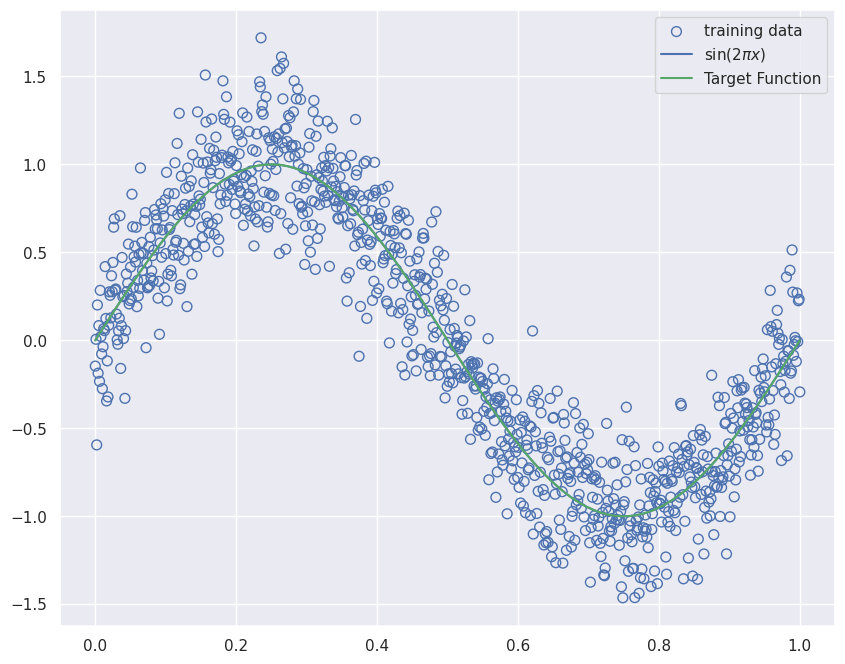

In [54]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 1000, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()

y_pred = w * x + b

L = (1/n) * Σ(y_pred - y)^2

a) Gradient with respect to w: ∂L/∂w = (2/n) * Σ(y_pred - y) * x

b) Gradient with respect to b: ∂L/∂b = (2/n) * Σ(y_pred - y)

In [84]:
def polynomial_features(X, M):
    return np.stack([X**i for i in range(1, M+1)], axis=1)

def mse_loss(y, y_pred):
    return np.mean(np.square(y - y_pred))

def gradient(X, y, y_pred):
    n = len(y)
    dw = (2/n) * X.T.dot(y_pred - y)
    db = (2/n) * np.sum(y_pred - y)
    return dw, db

def mse_loss_with_regularization(y, y_pred, w, lambda_):
    mse = mse_loss(y, y_pred)
    l2_reg = lambda_ * np.sum(np.square(w))
    return mse + l2_reg

def gradient_with_regularization(X, y, y_pred, w, lambda_):
    n = len(y)
    dw = (2/n) * X.T.dot(y_pred - y) + 2 * lambda_ * w
    db = (2/n) * np.sum(y_pred - y)
    return dw, db

In [85]:
def linear_regression(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, polynomial_ft_order, lambda_):
    X_poly_train = polynomial_features(x_train, polynomial_ft_order)
    X_poly_test = polynomial_features(x_test, polynomial_ft_order)

    w, b = np.expand_dims(np.random.random(polynomial_ft_order), axis=-1), 0
    n = len(y_train)

    y_train = np.expand_dims(y_train, axis=-1)
    y_test = np.expand_dims(y_test, axis=-1)

    training_losses = []
    validation_losses = []

    for e in range(epochs):
        # Shuffle the data
        shuffled_idxs = np.random.permutation(n)
        X_shuffled = X_poly_train[shuffled_idxs]
        y_shuffled = y_train[shuffled_idxs]

        for i in range(0, n, batch_size):
            batch_idxs = slice(i, min(i + batch_size, n))
            X_batch = X_shuffled[batch_idxs]
            y_batch = y_shuffled[batch_idxs]

            y_pred = X_batch.dot(w) + b # Predictions

            dw, db = gradient_with_regularization(X_batch, y_batch, y_pred, w, lambda_) # Gradients

            w -= learning_rate * dw
            b -= learning_rate * db

        if e % 10 == 0:
            training_losses.append(mse_loss_with_regularization(y_train, X_poly_train.dot(w) + b, w, lambda_))
            validation_losses.append(mse_loss_with_regularization(y_test, X_poly_test.dot(w) + b, w, lambda_))

    return w, b, training_losses, validation_losses

In [86]:
# Hyperparameters
epochs = 1000
batch_size = 32
learning_rate = 0.1
polynomial_ft_order = 9
regularization_lambda = 0.0

w, b, training_losses, validation_losses = linear_regression(x_train, y_train,
    x_test, y_test, epochs, batch_size, learning_rate, polynomial_ft_order, regularization_lambda)

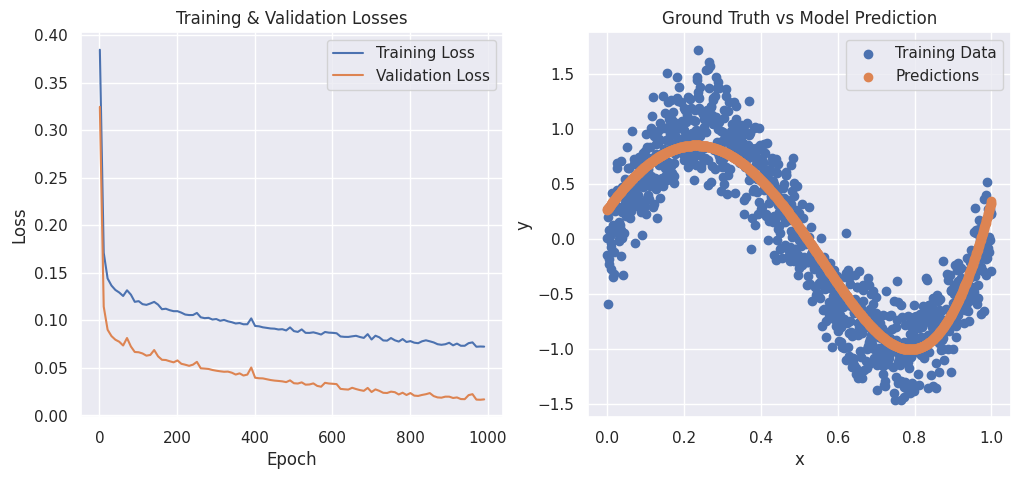

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, epochs+1, 10), training_losses, label="Training Loss")
ax1.plot(range(1, epochs+1, 10), validation_losses, label="Validation Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Losses')
ax1.legend()

ax2.scatter(x_train, y_train, label="Training Data")
ax2.scatter(x_train, polynomial_features(x_train, polynomial_ft_order).dot(w) + b, label="Predictions")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Ground Truth vs Model Prediction')
ax2.legend()

In [88]:
def linear_regression_with_momentum(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, polynomial_ft_order, lambda_, momentum):
    X_poly_train = polynomial_features(x_train, polynomial_ft_order)
    X_poly_test = polynomial_features(x_test, polynomial_ft_order)
    w = np.expand_dims(np.random.random(polynomial_ft_order), axis=-1)
    b = 0
    n = len(y_train)
    y_train = np.expand_dims(y_train, axis=-1)
    y_test = np.expand_dims(y_test, axis=-1)
    training_losses = []
    validation_losses = []

    # Initialize velocity
    v_w = np.zeros_like(w)
    v_b = 0

    for e in range(epochs):
        # Shuffle the data
        shuffled_idxs = np.random.permutation(n)
        X_shuffled = X_poly_train[shuffled_idxs]
        y_shuffled = y_train[shuffled_idxs]

        for i in range(0, n, batch_size):
            batch_idxs = slice(i, min(i + batch_size, n))
            X_batch = X_shuffled[batch_idxs]
            y_batch = y_shuffled[batch_idxs]

            y_pred = X_batch.dot(w) + b  # Predictions
            dw, db = gradient_with_regularization(X_batch, y_batch, y_pred, w, lambda_)  # Gradients

            # Update velocity
            v_w = momentum * v_w + (1-momentum) * learning_rate * dw
            v_b = momentum * v_b + (1-momentum) * learning_rate * db

            # Update parameters
            w -= v_w
            b -= v_b

        if e % 10 == 0:
            training_losses.append(mse_loss_with_regularization(y_train, X_poly_train.dot(w) + b, w, lambda_))
            validation_losses.append(mse_loss_with_regularization(y_test, X_poly_test.dot(w) + b, w, lambda_))

    return w, b, training_losses, validation_losses

In [89]:
# Reuse Other Hyperparameters for fair comparison
momentum = 0.9

w_2, b_2, training_losses_2, validation_losses_2 = linear_regression_with_momentum(
        x_train, y_train, x_test, y_test, epochs, batch_size,
        learning_rate, polynomial_ft_order, regularization_lambda, momentum
    )

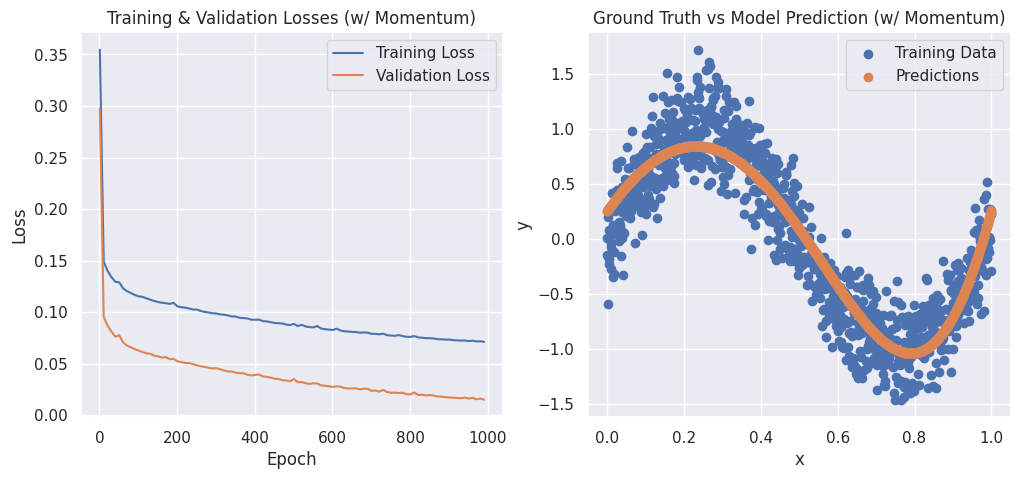

In [90]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))

ax3.plot(range(1, epochs+1, 10), training_losses_2, label="Training Loss")
ax3.plot(range(1, epochs+1, 10), validation_losses_2, label="Validation Loss")
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Training & Validation Losses (w/ Momentum)')
ax3.legend()

ax4.scatter(x_train, y_train, label="Training Data")
ax4.scatter(x_train, polynomial_features(x_train, polynomial_ft_order).dot(w_2) + b_2, label="Predictions")
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('Ground Truth vs Model Prediction (w/ Momentum)')
ax4.legend()

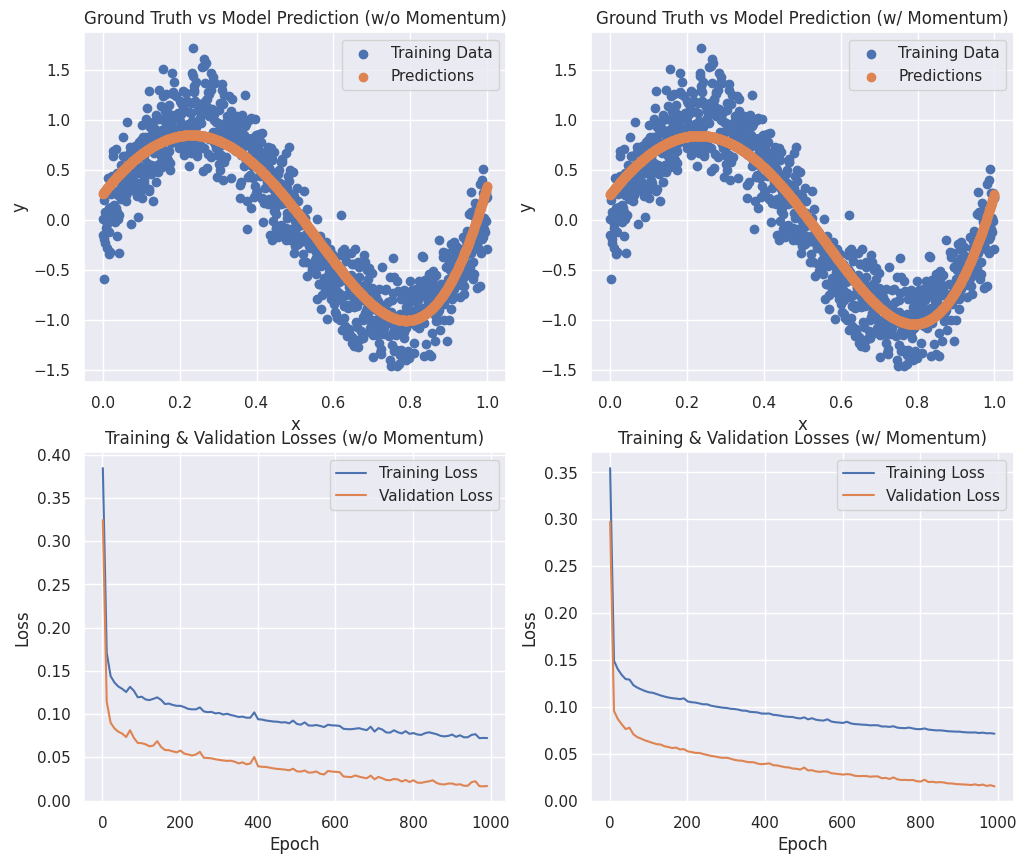

In [91]:
fig, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=(12, 10))

ax3.scatter(x_train, y_train, label="Training Data")
ax3.scatter(x_train, polynomial_features(x_train, polynomial_ft_order).dot(w) + b, label="Predictions")
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Ground Truth vs Model Prediction (w/o Momentum)')
ax3.legend()

ax4.scatter(x_train, y_train, label="Training Data")
ax4.scatter(x_train, polynomial_features(x_train, polynomial_ft_order).dot(w_2) + b_2, label="Predictions")
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('Ground Truth vs Model Prediction (w/ Momentum)')
ax4.legend()

ax5.plot(range(1, epochs+1, 10), training_losses, label="Training Loss")
ax5.plot(range(1, epochs+1, 10), validation_losses, label="Validation Loss")
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Loss')
ax5.set_title('Training & Validation Losses (w/o Momentum)')
ax5.legend()

ax6.plot(range(1, epochs+1, 10), training_losses_2, label="Training Loss")
ax6.plot(range(1, epochs+1, 10), validation_losses_2, label="Validation Loss")
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Loss')
ax6.set_title('Training & Validation Losses (w/ Momentum)')
ax6.legend()